In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import warnings
import matplotlib.pyplot as plt # type: ignore




In [2]:
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
df = pd.read_csv('winequality-red.csv', sep=';')
X = df.iloc[:,:-1].values  # illoc -> int location, take all row and all column without last column
y= (df.quality >=6).astype(int).values #take quality row in data if equal to 6 and grater then 6 say True other wise false, astype works True->1, False->0 
df.sample(5)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
41,8.8,0.61,0.30,2.8,0.088,17.0,46.0,0.99760,3.26,0.51,9.3,4
551,9.4,0.43,0.24,2.8,0.092,14.0,45.0,0.99800,3.19,0.73,10.0,6
755,7.8,0.91,0.07,1.9,0.058,22.0,47.0,0.99525,3.51,0.43,10.7,6
1209,6.2,0.39,0.43,2.0,0.071,14.0,24.0,0.99428,3.45,0.87,11.2,7
1237,7.1,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,12.8,6


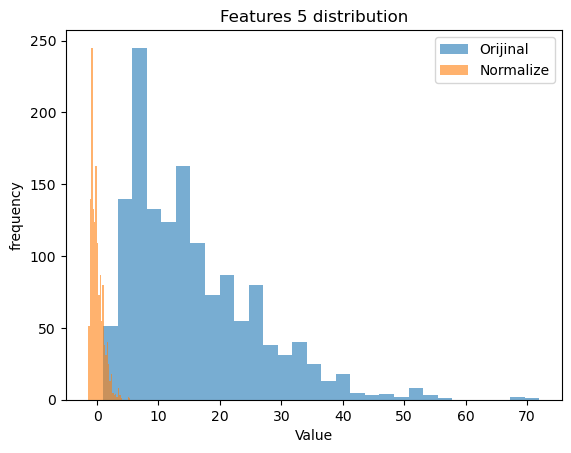

In [4]:
scaler = StandardScaler() # mean 0, variance 1
X_norm = scaler.fit_transform(X)

feature_idx = 5 # try 1 to 11 

plt.figure()
plt.hist(X[:, feature_idx], bins=30, alpha=0.6, label='Orijinal') # take al X rows, feature_idx = which feature column you want to visulize, bins= with 30 bins histogram will have 30 bars, alpha is opacity
plt.hist(X_norm[:, feature_idx], bins=30, alpha=0.6, label='Normalize')
plt.title(f"Features {feature_idx} distribution")
plt.xlabel("Value")
plt.ylabel("frequency")
plt.legend() #  adds a legend to your plot, you can see in top left side 
plt.show()




In [5]:
"""class SmalMLP(nn.Module):
    def __init__(self,in_dim):  # im_dim -> we are using features 11 dim
        super().__init__()  # for inheretence
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        for m in self.net:  # we traverse each nn.Linear layer within network 
            if isinstance(m, nn.Linear): # we just procces with linear layers, not with others
                nn.init.xavier_uniform_(m.weight) # start weights with xavier
                nn.init.zeros_(m.bias)
    def forward(self,x):
        return self.net(x)"""

'class SmalMLP(nn.Module):\n    def __init__(self,in_dim):  # im_dim -> we are using features 11 dim\n        super().__init__()  # for inheretence\n        self.net = nn.Sequential(\n            nn.Linear(in_dim, 128),\n            nn.ReLU(),\n            nn.Linear(128, 64),\n            nn.ReLU(),\n            nn.Linear(64, 2)\n        )\n        for m in self.net:  # we traverse each nn.Linear layer within network \n            if isinstance(m, nn.Linear): # we just procces with linear layers, not with others\n                nn.init.xavier_uniform_(m.weight) # start weights with xavier\n                nn.init.zeros_(m.bias)\n    def forward(self,x):\n        return self.net(x)'

we can also do with top one but we want to try at flexible model and ı want to try with a lot of combination of hiperparameters. we will use bottom one style.

In [6]:

def train_nn(X_tr, y_tr,X_val,y_val,layers,epochs=80,batch_size=32, lr=1e-4,weight_decay=1e-3,dropout=0.4,patience=15):
    device = torch.device('cpu')
    
    dims = [X_tr.shape[1]] + list(layers)+ [2] # we know that x is 2d array and i take features number of X, X -> layers -> 2
    modules= [] 
    
    for i in range(len(dims)-1): 
        modules.append(nn.Linear(dims[i],dims[i+1]))
        modules.append(nn.BatchNorm1d(dims[i+1]))
        if i < len(dims)-2:  # we dont want to add relu and dropout after the last layer 
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=dropout))
    model = nn.Sequential(*modules).to(device)  #i give the modules list to nn.Sequential, then ı give to device 
    
    for m in model:
        if isinstance(m,nn.Linear):  # we just arrange nn.Linear layers
            nn.init.xavier_uniform_(m.weight) # starts weights with xaiver
            nn.init.zeros_(m.bias)
            
    # loss func and class weights + cross entropy 
    class_weights = torch.tensor(np.bincount(y_tr).sum()/ np.bincount(y_tr), dtype= torch.float32).to(device) # keeps 1d array 
    #np.bincount(y_tr).sum()/ np.bincount(y_tr) # if which of the class values less then others, give big weight to less one. so, for unbalanced class distribution
    
    # does logits-> softmax -> log -> *-log
    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    
    # optimizer adam, actually if we choose L-BFGS is better for us cuz we have not much data
    optimizer = torch.optim.AdamW(model.parameters(),lr=lr,weight_decay=weight_decay)  
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',      # when val_acc not increase lr decrease
        factor=0.5,      # divide 2  
        patience=10,      # val_acc if not getting better in 10
    )
    
    # we get x and y datas on one dataset for  train and  value  
    ds_train = TensorDataset(torch.from_numpy(X_tr).float(),torch.from_numpy(y_tr).long())
    ds_val= TensorDataset(torch.from_numpy(X_val).float(),torch.from_numpy(y_val).long())
    
    # thanks to DataLoader Providing iterations in mini-batches from the dataset with features such as shuffle, parallel data reading (num_workers), sequential or random sampling.
    loader_train = DataLoader(ds_train, batch_size= batch_size, shuffle=True) #shuffle true is important cuz it mix datas in every epoch
    loader_val = DataLoader(ds_val, batch_size= batch_size, shuffle=False)
    
    # best loss is +infinitive no one (unless other inf) cannot bigger then best_loss
    best_loss = float('inf')
    counter = 0
    best_model_path = 'best_model.pth'
    
    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []

    for epoch in range(epochs):
        
        model.train()# model eğitim moduna alınır dropout veya batchnorm varsa davranışı değişir
        running_train_loss = 0.0
        correct_train =0
        total_train =0
        
        for xb,yb in loader_train:
            xb,yb = xb.to(device),yb.to(device)
            # Forward + Loss
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_function(logits, yb)
            # Backward + Update
            loss.backward()  #backprop, backprop does not update parameters.
            optimizer.step() #update parameters here
            # add loss
            running_train_loss += loss.item() * xb.size(0) # mean loss * batch size
            
            preds = logits.argmax(dim=1)
            correct_train +=(preds == yb).sum().item() # item() funct convert dtpye tensor to python dtype float or int
            total_train += yb.size(0) #yb batch size

        train_loss = running_train_loss / total_train
        train_acc  = correct_train   / total_train
        train_losses.append(train_loss)
        train_accs.append(train_acc)


        model.eval() # inference mod, dropout layers disabled, take mean of batch norm,
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad(): # we will not calculate gradians so we dont want to waste of memory space
            for xb,yb in loader_val: # we take data from loader_val 
                xb,yb = xb.to(device), yb.to(device)
                logits = model(xb)
                
                loss = loss_function(logits, yb)
                running_val_loss += loss.item()*xb.size(0)
                
                preds = logits.argmax(dim=1)
                correct_val += (preds == yb).sum().item()
                total_val += yb.size(0)
        val_loss = running_val_loss / total_val
        val_acc  = correct_val     / total_val
        val_losses.append(val_loss)
        val_accs.append(val_acc)
            
        scheduler.step(val_acc) #check val_acc   
        
        # check early stopping / we want to find least val_loss
        if running_val_loss < best_loss:
            best_loss = running_val_loss
            counter = 0
            torch.save(model.state_dict(),best_model_path)
        else:
            counter +=1
            if counter >= patience:
                print(f'Early Stopping: {epoch+1}. epochta (val_loss={(running_val_loss/epoch+1):.4f})')
                break
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch:3d} | "
              f"train_loss={train_losses[-1]:.4f}, val_loss={val_losses[-1]:.4f} | "
                f"train_acc={train_accs[-1]:.4f}, val_acc={val_accs[-1]:.4f} | "
              f"lr={current_lr:.2e}")
  

    model.load_state_dict(torch.load(best_model_path))
    model.eval()    
    with torch.no_grad():
        preds = model(torch.from_numpy(X_val).float().to(device)).argmax(dim=1).cpu().numpy() # model generates logit, argmax takes the index of the class with the highest score as 0 or 1 so that the class reaches the predictors, numpy converts the results to numpy string
        
    return preds,model,train_losses,val_losses, train_accs,val_accs # preds 0 or 1 labels, model is trained pytorch model, we can save and use this object for future uses.
    

detach() vs torch.no_grad():
1. **Memory**
- `.detach()` creates a new tensor (with the same data reference, but detached from the graph).
- `no_grad` does not create any new tensor; it simply closes the current options and interpolation.

2. **Graph Behavior**
- If you re-open the gradient with `detached_tensor.requires_grad_()` after `.detach()`, you can start a new graph.
- When you move out of the `no_grad` block, automatic differentiation continues; `.detach()` permanently detaches the tensor.

In [7]:

X_train, X_test, y_train, y_test = train_test_split(X_norm,y, test_size=0.2, stratify=y,random_state=0)
preds ,model_nn, train_losses, val_losses, train_accs, val_accs = train_nn(X_train,y_train,X_test,y_test, [512,256],epochs=200, batch_size=8,weight_decay=1e-3,lr=1e-3, dropout=0.3,patience=10)

# probs_nn = torch.softmax(model_nn(torch.from_numpy(X_test).float()),dim=1)[:,1].detach().numpy()
# ı just want to saparete on top line 

logits_test = model_nn(torch.from_numpy(X_test).float()) # x_test to numpy array float32, than forward pass in model's returun [N_test,2] 2 is for classes
probs = torch.softmax(logits_test,dim=1) # softmax does exp(logit)/sum(exp(logit))  retruns exp [0.333,0.667]
probs_nn = probs[:,1] #probs[:,0] = class 0 likelyhood, probs[:,1] class 1 likelyhod, its return 1 dimension tensor [N_test]
probs_nn = probs_nn.detach().numpy() # detach() 
preds_nn_only = (probs_nn >= 0.5).astype(int)
acc_nn = accuracy_score(y_test, preds_nn_only) * 100
print(f"NN Test Accuracy: {acc_nn:.2f}%")



Epoch   0 | train_loss=0.5886, val_loss=0.5255 | train_acc=0.7016, val_acc=0.7766 | lr=1.00e-03
Epoch   1 | train_loss=0.5393, val_loss=0.5184 | train_acc=0.7291, val_acc=0.7595 | lr=1.00e-03
Epoch   2 | train_loss=0.5531, val_loss=0.5376 | train_acc=0.7128, val_acc=0.7663 | lr=1.00e-03
Epoch   3 | train_loss=0.5303, val_loss=0.5214 | train_acc=0.7403, val_acc=0.7801 | lr=1.00e-03
Epoch   4 | train_loss=0.5392, val_loss=0.5439 | train_acc=0.7334, val_acc=0.7663 | lr=1.00e-03
Epoch   5 | train_loss=0.5269, val_loss=0.5272 | train_acc=0.7343, val_acc=0.7595 | lr=1.00e-03
Epoch   6 | train_loss=0.5290, val_loss=0.5179 | train_acc=0.7412, val_acc=0.7629 | lr=1.00e-03
Epoch   7 | train_loss=0.5233, val_loss=0.5066 | train_acc=0.7420, val_acc=0.8076 | lr=1.00e-03
Epoch   8 | train_loss=0.5347, val_loss=0.5061 | train_acc=0.7395, val_acc=0.7973 | lr=1.00e-03
Epoch   9 | train_loss=0.5255, val_loss=0.5224 | train_acc=0.7334, val_acc=0.7766 | lr=1.00e-03
Epoch  10 | train_loss=0.5347, val_loss=

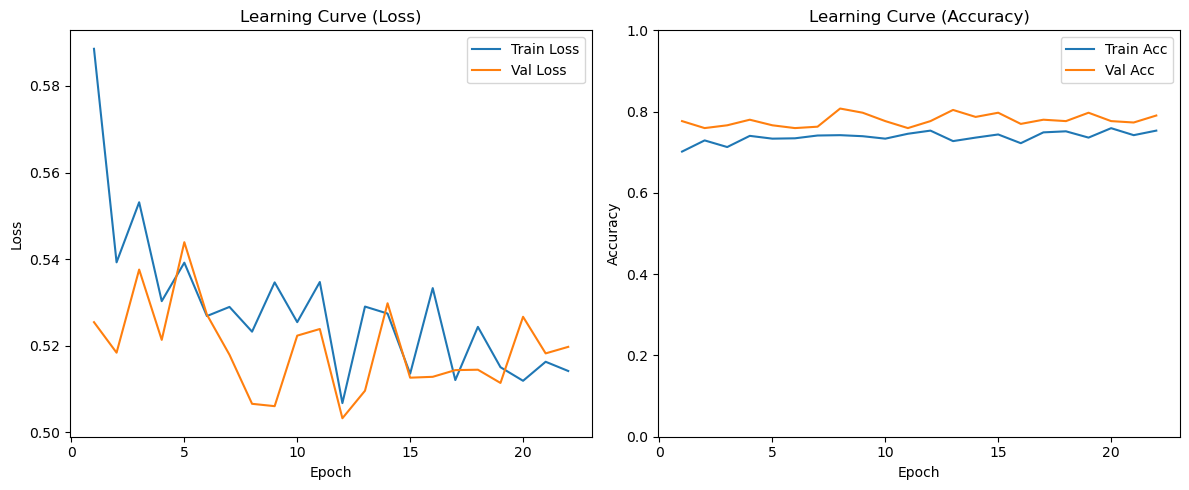

In [8]:
import matplotlib.pyplot as plt

# 1) epochs 
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# 2) Loss 
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses,   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Learning Curve (Loss)")
plt.legend()

# 3) Accuracy 
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs,   label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.title("Learning Curve (Accuracy)")
plt.legend()

plt.tight_layout()
plt.show()


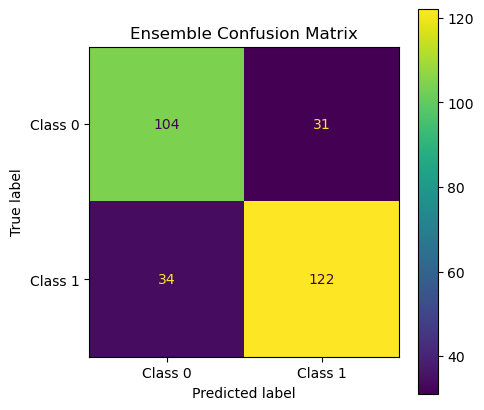

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


preds_ensemble = preds  
cm = confusion_matrix(y_test, preds_ensemble, labels=[0,1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Class 0', 'Class 1']
)
fig, ax = plt.subplots(figsize=(5,5))
disp.plot(ax=ax)
plt.title("Ensemble Confusion Matrix")
plt.show()
